In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import scipy.constants as sc
import emcee
from scipy.optimize import minimize

In [9]:
data = np.loadtxt('data.txt')
# Column 1 = frequency from Table 4 of Fixsen et al., units = cm^-1
# Column 2 = FIRAS monopole spectrum computed as the sum
#             of a 2.725 K BB spectrum and the
#             residual in column 3, units = MJy/sr
# Column 3 = residual monopole spectrum from Table 4 of Fixsen et al.,
#             units = kJy/sr
# Column 4 = spectrum uncertainty (1-sigma) from Table 4 of Fixsen et al.,
#             units = kJy/sr
# Column 5 = modeled Galaxy spectrum at the Galactic poles from Table 4 of
#             Fixsen et al., units = kJy/sr

In [10]:
n = len(data)
freq = data[0:n,0]*100
spec = data[0:n,1]
er = data[0:n,3]

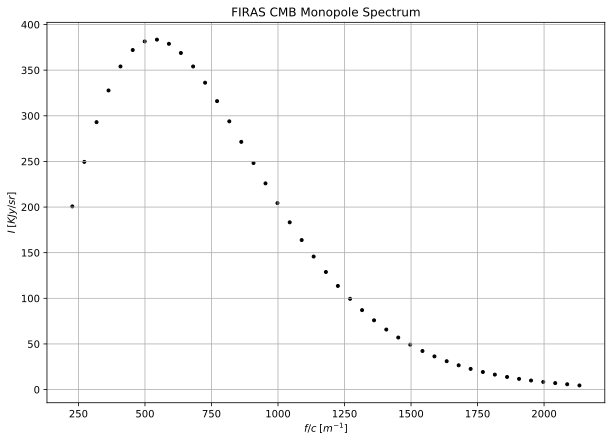

In [12]:
plt.rcParams['figure.figsize'] = (10,7)
#plt.errorbar(freq, spec, yerr = er, marker='.',color="black")
plt.scatter(freq, spec, marker='.',color="black")

plt.title("FIRAS CMB Monopole Spectrum",loc='center')
#plt.xscale('log')
plt.xlabel('$f/c \; [m^{-1}]$')
plt.ylabel('$I \; [KJy/sr]$')
plt.grid()
plt.show()

## Usaremos la ley de planck:
## $I(\nu,T)d\nu = g\frac{2 h\nu^3}{c^2}\frac{1}{e^{\frac{h\nu}{kT}}-1}d\nu$
## Donde $g = 10e25$ es un factor adimensional de reescalamiento de la función para usar las mismas unidades del dataframe, que son Mega Janskys por estereorradián.
## Tomamos en cuenta también que la frecuencia del dataframe es frecuencia sobre velocidad de la luz, y está en unidades de $[cm^{-1}]$, por lo que hay que pasarla a metros antes de cualquier cosa.

In [5]:
def planck(nu,T):
    return ((2*sc.h*nu**3))*(1/((np.exp(sc.h*nu*sc.c/(sc.k*T)))-1))*10**20*sc.c

In [13]:
nu = freq
T = [2,2.3,2.5,2.8,3]
I,I2,I3,I4,I5 = planck(nu,T[0]),planck(nu,T[1]),planck(nu,T[2]),planck(nu,T[3]),planck(nu,T[4])

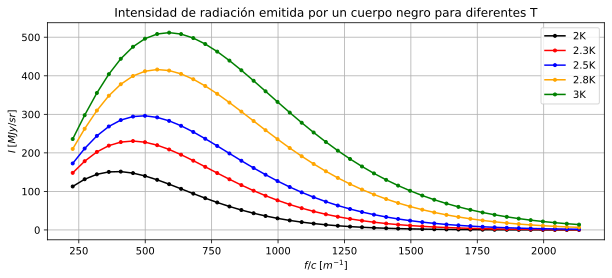

In [14]:
plt.rcParams['figure.figsize'] = (10,4)

plt.plot(nu,I,color="black",marker='.',label='2K')
plt.plot(nu,I2,color="red",marker='.',label='2.3K')
plt.plot(nu,I3,color="blue",marker='.',label='2.5K')
plt.plot(nu,I4,color="orange",marker='.',label='2.8K')
plt.plot(nu,I5,color="green",marker='.',label='3K')
plt.title("Intensidad de radiación emitida por un cuerpo negro para diferentes T",loc='center')
#plt.xscale('log')
plt.xlabel('$f/c \; [m^{-1}]$')
plt.ylabel('$I \; [MJy/sr]$')
plt.legend()
#plt.xlim(1e12,10e14)
#plt.ylim(0,2.3e-10)
plt.grid()
plt.show()

In [15]:
def posterior(T):
    nu = freq
    fx = planck(nu,T)  
    llt = sum(-(1/(2*er**2))*(fx-spec)**2)
    return llt

In [690]:
pos = [3] + 1e-4 * np.random.randn(25, 1)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
sampler.run_mcmc(pos, 150000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████| 150000/150000 [05:45<00:00, 433.64it/s]


In [693]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)    #flat=True
print(flat_samples.shape)

(249825, 1)


In [696]:
from IPython.display import display, Math
labels = [r"T"]
res = np.zeros(ndim)
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    res[i] = mcmc[1]
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{+{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

In [771]:
def func(w):
    x = sum((spec-planck(nu,w))**2/er**2)
    return x

In [772]:
T = 1
sol = minimize(func,T)
txt = "\mathrm{{{2}}} = {0:.5f} K"
txt = txt.format(sol.x[0],q[0], labels[i])
display(Math(txt))

<IPython.core.display.Math object>

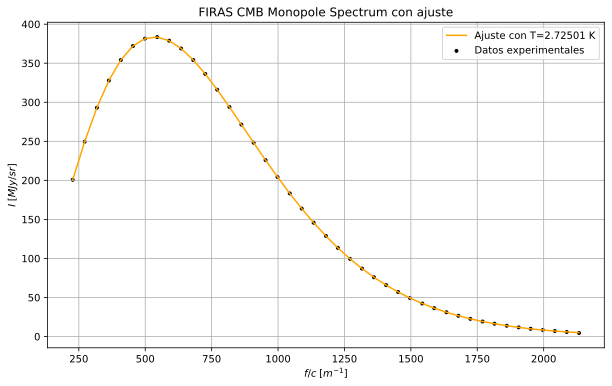

In [706]:
plt.rcParams['figure.figsize'] = (10,6)
#plt.errorbar(freq, spec, yerr = er,marker='.',color="black")
plt.scatter(freq, spec, marker='.',color="black", label="Datos experimentales")
plt.plot(freq, planck(freq,2.725015),color="orange",label="Ajuste con T=2.72501 K")
plt.title("FIRAS CMB Monopole Spectrum con ajuste",loc='center')
#plt.xscale('log')
plt.xlabel('$f/c \; [m^{-1}]$')
plt.ylabel('$I \; [MJy/sr]$')
plt.legend()
#plt.ylim(0,4.3e-25)
plt.grid()
plt.show()

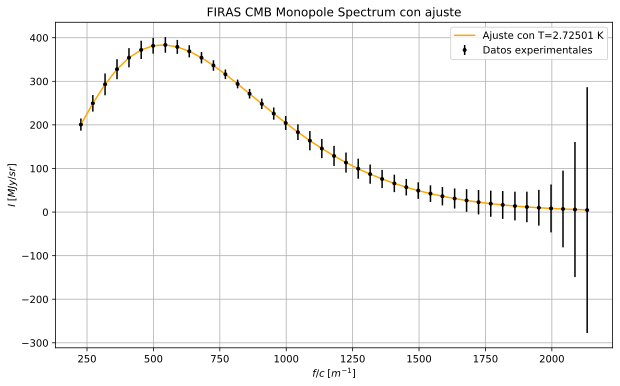

In [705]:
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(freq, planck(freq,2.725015),color="orange",label="Ajuste con T=2.72501 K")
plt.errorbar(freq, spec, yerr = er, fmt='.',color="black",label="Datos experimentales")
#plt.scatter(freq, spec, marker='.',color="black", label="Datos experimentales")
plt.title("FIRAS CMB Monopole Spectrum con ajuste",loc='center')
#plt.xscale('log')
plt.xlabel('$f/c \; [m^{-1}]$')
plt.ylabel('$I \; [MJy/sr]$')
plt.legend()
#plt.ylim(0,4.3e-25)
plt.grid()
plt.show()